In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
sns.set_context('talk')
pd.set_option('max_columns',99)
pd.set_option('max_rows',99)
%matplotlib inline


Using TensorFlow backend.


# EDA

In [2]:
orders = pd.read_csv("./data/olist_orders_dataset.csv", engine='python')
ordered_products = pd.read_csv("./data/olist_order_items_dataset.csv", engine='python')
product_info = pd.read_csv("./data/olist_products_dataset.csv", engine='python')

In [3]:
df2 = orders.merge(ordered_products, on='order_id')
data = df2.merge(product_info, on='product_id')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 21 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_status                     112650 non-null object
order_purchase_timestamp         112650 non-null object
order_approved_at                112635 non-null object
order_delivered_carrier_date     111456 non-null object
order_delivered_customer_date    110196 non-null object
order_estimated_delivery_date    112650 non-null object
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
seller_id                        112650 non-null object
price                            112650 non-null float64
freight_value                    112650 non-null float64
product_category_name            111047 non-null object
product_name_lenght              111047 non-null float64
product_description_lenght       111047 non-nul

In [5]:
data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3    delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-08-17 15:28:33           2017-08-18 14:44:43   
2          2017-08-04 17:35:43           2017-08-07 18:30:01   
3          2017-10-27 16:48:46           2017-11-07 18:04:59   
4          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-08-28 00:00:00              1   
2           2017-08-15 00:00:00              1   
3           2017-11-13 00:00:00              1   
4           2018-08-13 00:00:00              1   

                         product_id                         seller_id   price  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
3  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
4  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962  118.70   

   freight_value  product_category_name  product_name_lenght  \
0           8.72  utilidades_domesticas                 40.0   
1           7.78  utilidades_domesticas                 40.0   
2           7.78  utilidades_domesticas                 40.0   
3          14.10  utilidades_domesticas                 40.0   
4          22.76             perfumaria                 29.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       268.0                 4.0             500.0   
1                       268.0                 4.0             500.0   
2                       268.0                 4.0             500.0   
3                       268.0                 4.0             500.0   
4                       178.0                 1.0             400.0   

   product_length_cm  product_height_cm  product_width_cm  
0               19.0                8.0              13.0  
1               19.0                8.0              13.0  
2               19.0                8.0              13.0  
3               19.0                8.0              13.0  
4               19.0               13.0              19.0

## Criando features de analise de DateTime

In [6]:
dt_columns = ['order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date',
 'order_estimated_delivery_date','order_approved_at']
for col in dt_columns:
    data[col] = pd.to_datetime(data[col])
data['tempo_de_entrega'] = data['order_delivered_customer_date'] - data['order_delivered_carrier_date']
data['tempo_apos_pagamento_aprovado'] = data['order_delivered_carrier_date'] - data['order_approved_at'] 
data['tempo_de_aprovacao'] = data['order_approved_at'] - data['order_purchase_timestamp']
data['chegou_no_esperado'] = data['order_delivered_customer_date'] <= data['order_estimated_delivery_date']

In [7]:
data.set_index('order_purchase_timestamp',inplace=True)
data['date'] = data.index
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear

In [8]:
data.head()

order_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7   
2017-08-15 18:29:31       128e10d95713541c87cd1a2e48201934   
2017-08-02 18:24:47       0e7e841ddf8f8f2de2bad69267ecfbcf   
2017-10-23 23:26:46       bfc39df4f36c3693ff3b63fcbea9e90a   
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-02 10:56:33       9ef432eb6251297304e76186b10a928d    delivered   
2017-08-15 18:29:31       a20e8105f23924cd00833fd87daa0831    delivered   
2017-08-02 18:24:47       26c7ac168e1433912a51b924fbd34d34    delivered   
2017-10-23 23:26:46       53904ddbea91e1e92b2b3f1d09a7af86    delivered   
2018-07-24 20:41:37       b0830fb4747a6c6d20dea0b8c802d7ef    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33      2017-10-02 11:07:15          2017-10-04 19:55:00   
2017-08-15 18:29:31      2017-08-15 20:05:16          2017-08-17 15:28:33   
2017-08-02 18:24:47      2017-08-02 18:43:15          2017-08-04 17:35:43   
2017-10-23 23:26:46      2017-10-25 02:14:11          2017-10-27 16:48:46   
2018-07-24 20:41:37      2018-07-26 03:24:27          2018-07-26 14:31:00   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-02 10:56:33                2017-10-10 21:25:13   
2017-08-15 18:29:31                2017-08-18 14:44:43   
2017-08-02 18:24:47                2017-08-07 18:30:01   
2017-10-23 23:26:46                2017-11-07 18:04:59   
2018-07-24 20:41:37                2018-08-07 15:27:45   

                         order_estimated_delivery_date  order_item_id  \
order_purchase_timestamp                                                
2017-10-02 10:56:33                         2017-10-18              1   
2017-08-15 18:29:31                         2017-08-28              1   
2017-08-02 18:24:47                         2017-08-15              1   
2017-10-23 23:26:46                         2017-11-13              1   
2018-07-24 20:41:37                         2018-08-13              1   

                                                product_id  \
order_purchase_timestamp                                     
2017-10-02 10:56:33       87285b34884572647811a353c7ac498a   
2017-08-15 18:29:31       87285b34884572647811a353c7ac498a   
2017-08-02 18:24:47       87285b34884572647811a353c7ac498a   
2017-10-23 23:26:46       87285b34884572647811a353c7ac498a   
2018-07-24 20:41:37       595fac2a385ac33a80bd5114aec74eb8   

                                                 seller_id   price  \
order_purchase_timestamp                                             
2017-10-02 10:56:33       3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
2017-08-15 18:29:31       3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
2017-08-02 18:24:47       3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
2017-10-23 23:26:46       3504c0cb71d7fa48d967e0e4c94d59d9   29.99   
2018-07-24 20:41:37       289cdb325fb7e7f891c38608bf9e0962  118.70   

                          freight_value  product_category_name  \
order_purchase_timestamp                                         
2017-10-02 10:56:33                8.72  utilidades_domesticas   
2017-08-15 18:29:31                7.78  utilidades_domesticas   
2017-08-02 18:24:47                7.78  utilidades_domesticas   
2017-10-23 23:26:46               14.10  utilidades_domesticas   
2018-07-24 20:41:37               22.76             perfumaria   

                          product_name_lenght  product_description_lenght  \
order_purchase_timestamp                                                    
2017-10-02 10:56:33                      40.0                       268.0   
2017-08-15

##  

In [9]:
from workalendar.america import Brazil
bra = Brazil()
bra.holidays(2016)

[(datetime.date(2016, 1, 1), 'New year'),
 (datetime.date(2016, 4, 21), "Tiradentes' Day"),
 (datetime.date(2016, 5, 1), 'Labour Day'),
 (datetime.date(2016, 9, 7), 'Independence Day'),
 (datetime.date(2016, 10, 12), 'Our Lady of Aparecida'),
 (datetime.date(2016, 11, 2), "All Souls' Day"),
 (datetime.date(2016, 11, 15), 'Republic Day'),
 (datetime.date(2016, 12, 25), 'Christmas Day')]

In [10]:
for index in data.index.tolist():
    data.loc[index,'is_holiday'] = bra.is_working_day(index)

In [11]:
data['is_holiday'] = data['is_holiday'].astype('int')
data['chegou_no_esperado'] = data['chegou_no_esperado'].astype('int')

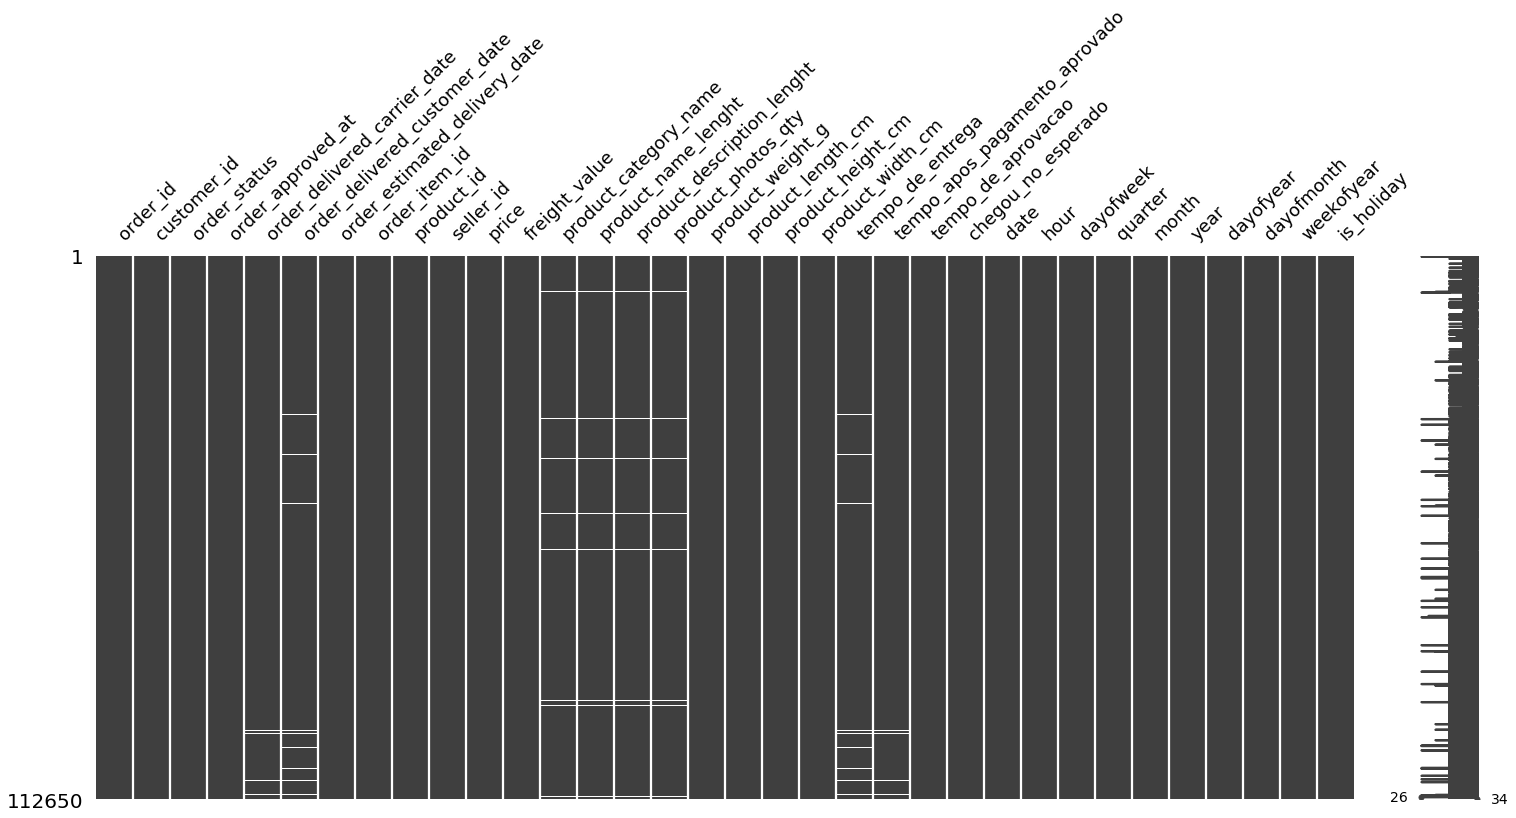

In [12]:
import missingno as msno

msno.matrix(data,fontsize=18)

In [13]:
import pandas_profiling 
pandas_profiling.ProfileReport(data)

## Recuperando informações perdidas no agrupamento

In [17]:
data_month = pd.read_csv('data_per_month.csv')

In [18]:
data_month.columns

Index(['Unnamed: 0', '12 MESES_inpc', '12 MESES_ipca', '3 MESES_inpc',
       '3 MESES_ipca', '6 MESES_inpc', '6 MESES_ipca', 'ANO',
       'Desvio padrão_selic', 'Fator diário_selic', 'Financeiro (R$)_selic',
       'Mediana_selic', 'Moda_selic', 'MÊS', 'MÊS_ipca', 'MÊS_onpc',
       'Média_selic', 'NO ANO_inpc', 'NO ANO_ipca', 'NÚMERO ÍNDICE_inpc',
       'NÚMERO ÍNDICE_ipca', 'Operações_selic', 'Taxa (% a.a.)_selic', 'date',
       'freight_per_item', 'order_freight', 'order_price', 'price_per_item',
       'product_id', 'quantity', 'review', 'total_price',
       'Índice de curtose_selic'],
      dtype='object')

In [20]:
ult_dom = data_month.loc[data_month['product_id']=='ffaf0af7eebb57c7f262b51ebb05dfd6']
ult_dom.shape

(6, 33)

### XGBoost

![](https://cdn-images-1.medium.com/max/1500/1*8T4HEjzHto_V8PrEFLkd9A.png)
#### Categorization of ensembles<br>

![](https://cdn-images-1.medium.com/max/1600/1*PaXJ8HCYE9r2MgiZ32TQ2A.png)
#### Comparison btw. bagging and boosting ensemble techniques

In [23]:
def split_per_year(data, split_year):
    return data[data.date<= split_year].copy(), \
           data[data.date >  split_year].copy()

In [37]:
ult_dom.date = pd.to_datetime(ult_dom.date)
train, test = split_per_year(ult_dom,pd.to_datetime('2018-02-01'))
print('Train Size; {} Test Size: {}'.format(len(train),len(test)))

Train Size; 4 Test Size: 2


/media/leandro/BKP/Mestrado/Item bath/trab_mlar/.venv/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
ult_dom.columns

Index(['Unnamed: 0', '12 MESES_inpc', '12 MESES_ipca', '3 MESES_inpc',
       '3 MESES_ipca', '6 MESES_inpc', '6 MESES_ipca', 'ANO',
       'Desvio padrão_selic', 'Fator diário_selic', 'Financeiro (R$)_selic',
       'Mediana_selic', 'Moda_selic', 'MÊS', 'MÊS_ipca', 'MÊS_onpc',
       'Média_selic', 'NO ANO_inpc', 'NO ANO_ipca', 'NÚMERO ÍNDICE_inpc',
       'NÚMERO ÍNDICE_ipca', 'Operações_selic', 'Taxa (% a.a.)_selic', 'date',
       'freight_per_item', 'order_freight', 'order_price', 'price_per_item',
       'product_id', 'quantity', 'review', 'total_price',
       'Índice de curtose_selic'],
      dtype='object')

In [30]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
features = [
       'Desvio padrão_selic', 'MÊS', 'Operações_selic', 'Taxa (% a.a.)_selic',
       'freight_per_item', 'order_freight', 'order_price', 'price_per_item',
        'review']
target = ['quantity']

scaled_x = MinMaxScaler([0,1]).fit(ult_dom[features])
scaled_y = MinMaxScaler([0,1]).fit(ult_dom[target])
X, Y     = scaled_x.transform(train[features].values),scaled_y.transform(train[target].values)
X_test   = scaled_x.transform(test[features].values) 

reg = xgb.XGBRegressor(n_estimators=1000,max_depth=100,random_state=42,objective='reg:logistic', learning_rate=0.3)

X_train,X_val,y_train,y_val = train_test_split(X, Y,test_size=0.1)

reg.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=None,
        verbose=2)

[0]	validation_0-rmse:0.477515
[2]	validation_0-rmse:0.442288
[4]	validation_0-rmse:0.416961
[6]	validation_0-rmse:0.398706
[8]	validation_0-rmse:0.385507
[10]	validation_0-rmse:0.375931
[12]	validation_0-rmse:0.368964
[14]	validation_0-rmse:0.363885
[16]	validation_0-rmse:0.360175
[18]	validation_0-rmse:0.35746
[20]	validation_0-rmse:0.355473
[22]	validation_0-rmse:0.354016
[24]	validation_0-rmse:0.352948
[26]	validation_0-rmse:0.352164
[28]	validation_0-rmse:0.351589
[30]	validation_0-rmse:0.351167
[32]	validation_0-rmse:0.350857
[34]	validation_0-rmse:0.350629
[36]	validation_0-rmse:0.350462
[38]	validation_0-rmse:0.35034
[40]	validation_0-rmse:0.350249
[42]	validation_0-rmse:0.350183
[44]	validation_0-rmse:0.350135
[46]	validation_0-rmse:0.350099
[48]	validation_0-rmse:0.350073
[50]	validation_0-rmse:0.350053
[52]	validation_0-rmse:0.350039
[54]	validation_0-rmse:0.350029
[56]	validation_0-rmse:0.350021
[58]	validation_0-rmse:0.350016
[60]	validation_0-rmse:0.350011
[62]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

xgb.plot_importance(reg, height=0.9)

In [32]:
def plot_performance(base_data,X,Y,date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Quantity of itens')
    plt.plot(base_data.index,base_data[target], label='data')
    plt.plot(X.index,Y[target], label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

In [34]:
import numpy as np

In [36]:
scaled_y_pred = reg.predict(X_test)
y_pred = scaled_y.inverse_transform([scaled_y_pred]) 
print('MSE: {}'.format(np.sqrt(mean_squared_error(test[target].values,y_pred.T))))
plot_performance(ult_dom,test[features],test[target], ult_dom.date.min, ult_dom.date.max(),
                 'Original and Predicted Data')

plot_performance(test,test[features],pd.DataFrame(y_pred.T,index=test.index,columns=['order_item_id']),test.index[0].date(), test.index[-1].date(),
                 'Test and Predicted Data')

MSE: 0.5250000804662702


AttributeError: 'Series' object has no attribute 'date'